**Summary:**

Write function to do training ⏭ test and display the results after the training.

#Setup

In [1]:
import tensorflow as tf
import numpy as np
import configparser
import pandas as pd
import datetime
import os

import matplotlib
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator
from google.colab import drive

In [2]:
%matplotlib inline

#Configuration

In [ ]:
# COCO Dataset Category Index
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
CATEGORY_COUNT = 90
CATEGORY_LABEL_ID_OFFSET = 1
# CATEGORY_INDEX_COCO = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

# Dataset images
IMG_SIZE = 1024

# Loss functions definitions
RPN_LOCALISATION = "Loss/RPNLoss/localization_loss"
RPN_OBJECTNESS = "Loss/RPNLoss/objectness_loss"
CLASSIFIER_LOCALISATION = "Loss/BoxClassifierLoss/localization_loss"
CLASSIFIER_CLASSIFICATION = "Loss/BoxClassifierLoss/classification_loss"

In [ ]:
# Adversarial patch
ADV_SIZE = 100
ADV_SIZE_RANDOM = False
ADV_LOCATION_RANDOM = False
ADV_ROTATION_RANDOM = False
ADV_BRIGHTNESS_RANDOM = False

# Training
LOSS_FUNCTION = CLASSIFIER_CLASSIFICATION
LOSS_SAMPLING_RATE = 1

ADAM_LEARNING_RATE = 0.001
ADAM_BETA_1 = 0.9
ADAM_BETA_2 = 0.999
ADAM_EPSILON = 1e-07
ADAM_AMSGRAD = False

BATCH_SIZE = 1
BATCH_NUMBER = 1000

#Results

In [ ]:
def init():
  # Mount google drive
  if not os.path.isdir("/content/drive"):
    drive.mount("/content/drive")

  # Create dir to store results in drive
  drive_dir = "/content/drive/MyDrive/Adversarial/results"
  if not os.path.isdir(drive_dir):
    os.mkdir(drive_dir)

  # Create new record folder in the dir with date & time
  ct = datetime.datetime.now()
  filename = f"{ct.year}-{ct.month}-{ct.day}_{ct.hour}:{ct.minute}:{ct.second}"
  result_dir = os.path.join(drive_dir, filename)
  if not os.path.isdir(result_dir):
    os.mkdir(result_dir)

  return result_dir

result_dir = init()

In [ ]:
config = configparser.ConfigParser()

config['ADV_PATCH'] = {}
adv_config = config['ADV_PATCH']
adv_config['SIZE'] = str(ADV_SIZE)
adv_config['SIZE_RANDOM'] = str(ADV_SIZE_RANDOM)
adv_config['LOCATION_RANDOM'] = str(ADV_LOCATION_RANDOM)
adv_config['ROTATION_RANDOM'] = str(ADV_ROTATION_RANDOM)
adv_config['BRIGHTNESS_RANDOM'] = str(ADV_BRIGHTNESS_RANDOM)

config['LOSS_FUNC'] = {}
loss_config = config['LOSS_FUNC']
loss_config['TYPE'] = LOSS_FUNCTION
loss_config['SAMPLING_RATE'] = str(LOSS_SAMPLING_RATE)

config['OPTIMISER'] = {}
optimiser_config = config['OPTIMISER']
optimiser_config['ADAM_LEARNING_RATE'] = str(ADAM_LEARNING_RATE)
optimiser_config['ADAM_BETA_1'] = str(ADAM_BETA_1)
optimiser_config['ADAM_BETA_2'] = str(ADAM_BETA_2)
optimiser_config['ADAM_EPSILON'] = str(ADAM_EPSILON)
optimiser_config['ADAM_AMSGRAD'] = str(ADAM_AMSGRAD)

config['TRAINING_LOOP'] = {}
training_loop_config = config['TRAINING_LOOP']
training_loop_config['BATCH_SIZE'] = str(BATCH_SIZE)
training_loop_config['BATCH_NUMBER'] = str(BATCH_NUMBER)

with open(result_dir + '/training.ini', 'w') as configfile:
  config.write(configfile)

In [ ]:
# Store adversarial patch
patch = tf.Variable(tf.constant(4.99, dtype=tf.float32, shape=[1, 100, 100, 3]))

def store_adv_checkpoint(variable, dir):
  adv_checkpoint = tf.train.Checkpoint(patch=variable)
  adv_checkpoint.write(os.path.join(dir, "adv_ckpt"))

store_adv_checkpoint(patch, result_dir)

In [ ]:
# Test restore adversarial patch
new_patch = tf.Variable(tf.constant(0.0, dtype=tf.float32, shape=[1, 100, 100, 3]))
another_checkpoint = tf.train.Checkpoint(patch=new_patch)
another_checkpoint.read(result_dir + '/adv_ckpt')

print(new_patch)

<tf.Variable 'Variable:0' shape=(1, 100, 100, 3) dtype=float32, numpy=
array([[[[4.99, 4.99, 4.99],
         [4.99, 4.99, 4.99],
         [4.99, 4.99, 4.99],
         ...,
         [4.99, 4.99, 4.99],
         [4.99, 4.99, 4.99],
         [4.99, 4.99, 4.99]],

        [[4.99, 4.99, 4.99],
         [4.99, 4.99, 4.99],
         [4.99, 4.99, 4.99],
         ...,
         [4.99, 4.99, 4.99],
         [4.99, 4.99, 4.99],
         [4.99, 4.99, 4.99]],

        [[4.99, 4.99, 4.99],
         [4.99, 4.99, 4.99],
         [4.99, 4.99, 4.99],
         ...,
         [4.99, 4.99, 4.99],
         [4.99, 4.99, 4.99],
         [4.99, 4.99, 4.99]],

        ...,

        [[4.99, 4.99, 4.99],
         [4.99, 4.99, 4.99],
         [4.99, 4.99, 4.99],
         ...,
         [4.99, 4.99, 4.99],
         [4.99, 4.99, 4.99],
         [4.99, 4.99, 4.99]],

        [[4.99, 4.99, 4.99],
         [4.99, 4.99, 4.99],
         [4.99, 4.99, 4.99],
         ...,
         [4.99, 4.99, 4.99],
         [4.99, 4.99, 4.9

In [ ]:
def store_loss_history_csv(loss_history, sampling_rate, dir):
  filepath = os.path.join(dir, 'loss_history.csv')
  length = len(loss_history)
  stop = length * sampling_rate

  x = np.arange(start=0, stop=stop, step=sampling_rate)
  y = loss_history

  plot = np.column_stack((x, y))

  df = pd.DataFrame(plot)
  df.to_csv(filepath, index=False)

  return filepath
  
losses = [i for i in range(10)]
store_loss_history_csv(losses, 2, result_dir)

'/content/drive/MyDrive/Adversarial/results/2022-4-13_18:28:54/loss_history.csv'

In [ ]:
def retrieve_loss_history_csv(filepath):
  df = pd.read_csv(filepath)
  x, y = np.moveaxis(df.to_numpy(), source=1, destination=0)
  
  sampling_rate = x[1] / y[1]
  loss_history = y

  return loss_history, sampling_rate

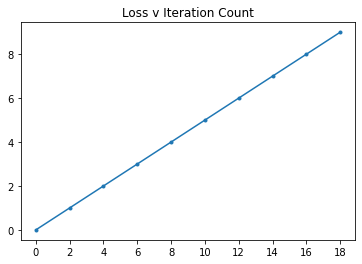

In [ ]:
def print_loss_history_plot(loss_history, sampling_rate, size=None):
  length = len(loss_history)
  stop = length * sampling_rate

  x = np.arange(start=0, stop=stop, step=sampling_rate).astype(int)
  y = loss_history

  fig, ax = plt.subplots(figsize=size)
  ax.plot(x, y, '.-')
  ax.title.set_text("Loss v Iteration Count")
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))

loss, rate = retrieve_loss_history_csv(result_dir + "/loss_history.csv")
print_loss_history_plot(loss, rate)

In [ ]:
def print_and_save_loss_history_plot(loss_history, sampling_rate, dir, size=None):
  length = len(loss_history)
  stop = length * sampling_rate

  x = np.arange(start=0, stop=stop, step=sampling_rate).astype(int)
  y = loss_history

  fig, ax = plt.subplots(figsize=size)
  ax.plot(x, y, '.-')
  ax.title.set_text("Loss v Iteration Count")
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  fig.savefig(os.path.join(dir, "loss_history.png"))

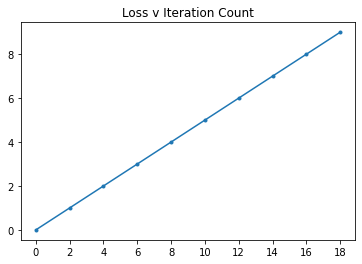

In [5]:
losses = [i for i in range(10)]
stop = length = len(losses) * 2
x = np.arange(start=0, stop=stop, step=2).astype(int)

fig, ax = plt.subplots()
ax.plot(x, losses, '.-')
ax.title.set_text("Loss v Iteration Count")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.savefig(os.path.join("/content", "loss_history.png"))